<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-theory" data-toc-modified-id="Introduction-and-theory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and theory</a></span></li><li><span><a href="#Developing-a-WCM-version-with-an-empirical-soil-model" data-toc-modified-id="Developing-a-WCM-version-with-an-empirical-soil-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Developing a WCM version with an empirical soil model</a></span><ul class="toc-item"><li><span><a href="#Some-further-remarks" data-toc-modified-id="Some-further-remarks-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Some further remarks</a></span></li></ul></li><li><span><a href="#Extracting-data" data-toc-modified-id="Extracting-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extracting data</a></span><ul class="toc-item"><li><span><a href="#Field-and-Sentinel-1-data" data-toc-modified-id="Field-and-Sentinel-1-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Field and Sentinel 1 data</a></span></li><li><span><a href="#The-Sentinel2-retrieved-parameters-from-KaSKA" data-toc-modified-id="The-Sentinel2-retrieved-parameters-from-KaSKA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The Sentinel2 retrieved parameters from KaSKA</a></span></li></ul></li></ul></div>

In [1]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model, extract_data
from SAR_retrieval_funcs import invert_field, do_plots, prepare_field_data

from SAR_retrieval_OLD import invert_field as invert_field_multiplicative
from SAR_retrieval_OLD import do_plots as do_plots_multiplicative

# Don't nag!
_ = np.seterr(divide='ignore', over="ignore", invalid='ignore')


# Combined retrieval from S1 and S2

## Introduction and theory
Most forms of the water cloud model tend to ignore multiple scattering terms, and thus have two contributions:

1. a canopy scattering contribution and,
2. a soil contribution, attenuated by the two way canopy path.

The general expression is

$$
\sigma_{pp}^{0} = \frac{1}{2}\omega_{c}\cos\theta\left[1-\exp\left(-\frac{2BV_2}{\cos\theta}\right)\right] + \exp\left(-\frac{2BV_2}{\cos\theta}\right)\sigma_{soil}^{0}.
$$

where $\omega_c$ is the canopy scattering term, $V_2$ is the equivalent canopy optical depth, $\mu=\cos\theta$ is the cosine of the angle of incidence and $\sigma_{soil}^{0}$ is the soil backscattering coefficient. $B$ is an empirical constant that mostly relates to the extinction of radiation through the canopy, and usually, $\omega_c=A\cdot V_1$, or in other words, the canopy scattering term is just an empirical scaling of some vegetation optical depth.

## Developing a WCM version with an empirical soil model

We'll develop some expressions for a WCM model with a Jacobian, as we'll be seeking to fit the WCM to observations and infer parameters.

For completeness, the WCM definition is as follows:

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\sigma_{soil}^{pq}.
$$

The previous definition assumes that the soil backscatter can be modelled as a function of something. In this case, we use the Oh 2004 model, which models soil backscatter for the VV, HH and HV polarisations as a function of volumetric soil moisture and a soil roughness term. Previous Oh versions of the model, and the Dubois models are also simple, but a bit more involved in their calculations. We'll take the Oh 2004 model, and have a poke around to see if we can get some insights.

The Oh model in essence can be written (for HV and VV polarisations) as a function of angle of incidence $\theta$, soil moisture $mv$ and wavenumber times rms roughness, $ks$:
$$
\begin{align}
\sigma_{HV} &= a\cdot b\\
\sigma_{VV} &= \frac{a\cdot b}{q}\\
q_0(\theta) &= 0.095\cdot\left(0.13 + \sin(1.5\theta)\right)^{1.4}\\
f_{q}(ks) &= (1 - \exp(-1.3 \cdot ks^{0.9}))\\
a &= 0.11\cdot mv^{0.7}  \cos(\theta)^{2.2}\\
b &= 1-\exp(-0.32\cdot ks^{1.8})\\
\end{align}
$$

If $\theta$ is identical for both polarisations, we have that
$$
\begin{align}
\sigma_{HV} &= f_{A}(\theta)\cdot mv^{0.7}\cdot f_{b}(ks)\\
\sigma_{VV} &= f_{A}(\theta)\cdot \frac{f_{b}(ks)}{q_{0}(\theta)\cdot f_{q}(ks)}\cdot mv^{0.7}
\end{align}
$$

The multiplicative model in linear units becomes an additive model in dB, suggesting that the Oh 2004 model can be inverted linearly. In this respect, we'd envisage the Oh 2004 model as a way of possibly obtaining prior parameter distributions. We note that the $ks$ parameter is a way of scaling up or down frequencies (as it represents a form of roughness scaled by wavelength). There's an intriguing concept if we can add some extra constraints on $ks$ to support retrieval within time series. 

These observations aren't extraordinary: a lot of approaches to soil moisture retrieval observe that changes in backscatter can directly be associated with soil moisture changes. Over small temporal windows, one can assume $ks$ constant, and thus use two or more observations to solve for $mv$. Most of the models do produce their own relationship, which are all slightly different to each other, and hard to compare as they often either use different geometric or polarimetric set-ups. However, all this body of literature suggests that this approach may be sufficient to model the soil.

Rewriting the model in dB scale, we have

$$
\begin{align}
\sigma_{hv} &= \log_{10}(fa_t) + \log_{10}(fb_k) + 0.7\cdot\log_{10}(mv) \\
\sigma_{vv} &= \left(\log_{10}(fa_t) - \log_{10}(q_{0})\right) \\
            &+ \left(\log_{10}(fb_k) - \log_{10}(fq_{k})\right) \\
            &+ 0.7*\log_{10}(mv) \\
\end{align}
$$

The first term on both equations is an angular term, whereas the second term is related to roughness. The third term is related to moisture. If we are not (initially) interested in roughness, we can just lump the roughness contributions into a polarisation-dependent parameter, e.g. $R_{pq}$, and we can then have a second, polarisation independent, moisture term $mv_{s}=0.7\log_{10}(mv)$. In other words, we can probably fit the soil model using a time series, particularly if we are willing to drop explainability of soil roughness (although this can be retrieved at a latter stage).

The above comments results in the complete WCM being:

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\left[K_{pq} + R_{pq} + mv_{s} \right].
$$

It's a simple model to differentiate, and for completeness, here are the partial derivatives (I define a few common functions at the top).


$$
\begin{align*}
\sigma_{soil} &= K_{pq} + R_{pq} + mv_{s}\\
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial \sigma_{pq}^{0}}{\partial A} &= V_{1} - V_{1}\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial B} &= \frac{-2V_2}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{1}} &= A - A\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{2}} &= \frac{-2B}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial mv_{s}} &= \tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial R_{pq}} &= \tau\\
\end{align*}
$$



The outshoot of this is that a retrieval strategy based on de-coupling angles, roughness and moisture is possible and not overly complicated. Under the assumption that roughness is slowly varying in time for the same location, we have a two or three parameter retrieval strategy (e.g. $mv,\,f_{B}(ks)$ and $f_{q}(ks)$). What's neat is that these parameters are **shared between polarisations**.


### Some further remarks

It is entirely possible to approximate the model above via a linear polynomial. The way to do this is to expand the first equation with a MacLaurin series. In order to deal with the non-linearity, you need some 3 to 4 terms, but this is dependent on the different model parameters. Left here as a footnote.

Another interesting thing is that the VV/VH ratio for bare soils should be insensitive to soil moisture. In the above formulation, we can see that the terms with $mv$ basically cancel out in the case of a polarisation ratio (this doesn't happen for VH/HH, as in RADARSAT, a combination that dampens the effect of $ks$ on $mv$).



## Extracting data

### Field and Sentinel 1 data

This is all coming from a CSV file. The next few blocks/cells do some first plotting of the data...

In [2]:
df, df_s2, fields = extract_data()

Text(0.5, 0, 'DoY/2017')

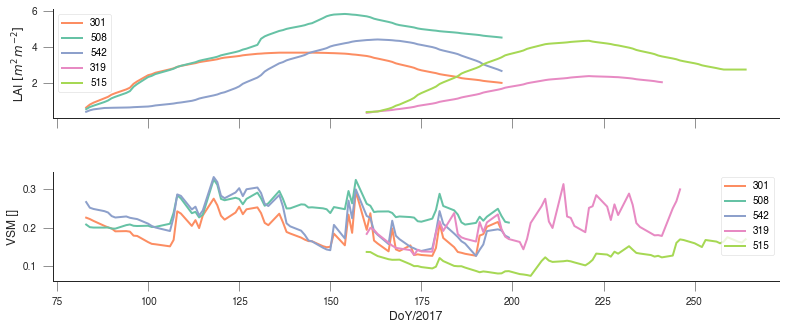

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], df[f"LAI_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")


axs[0].set_ylabel(r"LAI $[m^2\,m^{-2}]$")
axs[1].set_ylabel("VSM []")
axs[1].set_xlabel("DoY/2017")

The above plots show clear phenology diffrences between summer and winter crops, and a surprising amount of variation in soil moisture, although the peaks (hypothesising here that these are due to rainfall events) show a lot of commonality. 

Let's plot the backscatter. Broadly speaking, the ratio of VH/VV should follow a trend that might be linked to volumetric scattering, and hence vegetation optical depth, and hence some form of LAI...

Text(0.5, 0, 'DoY/2017')

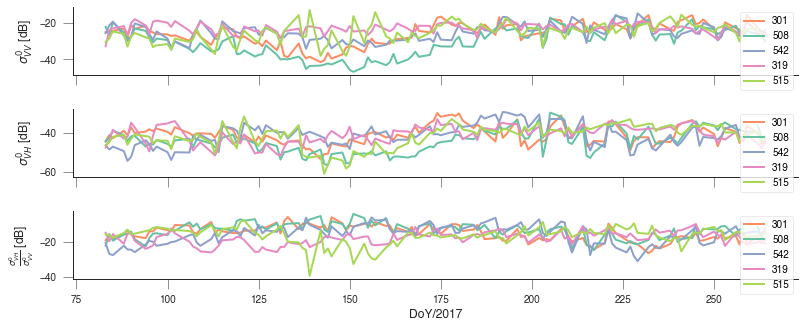

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vv_{field:s}"]),
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vh_{field:s}"]),
                          label=field))

    l3.append(axs[2].plot(df[f"doy_{field:s}"], 10*np.log(
        df[f"vh/vv_{field:s}"]),
        label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
axs[1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
axs[2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
axs[2].set_xlabel("DoY/2017")

You may need to squint your eyes a bit ;-)

### The Sentinel2 retrieved parameters from KaSKA

We have used KaSKA to retrieve land surface parameters. These are provided on a 20m resolution grid and are reported every 5 days. I have averaged them over each field. Note that this might have actually included some boundary pixels, but hey...

Let's have a look at how things stack up.

(0, 1)

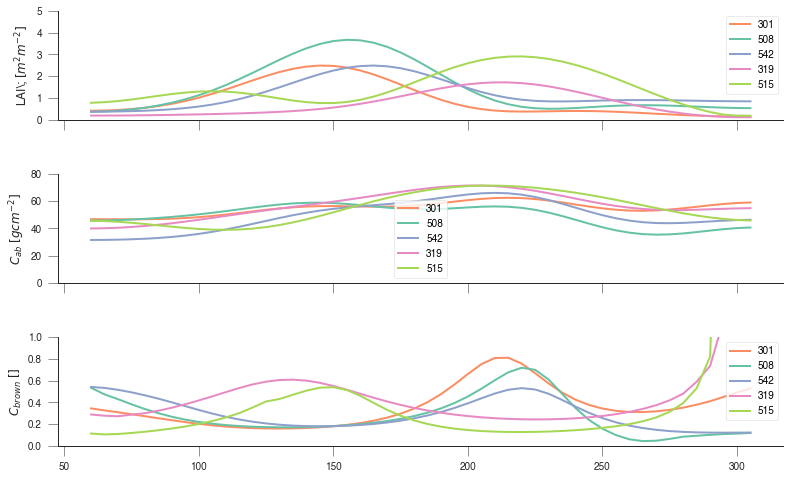

In [5]:

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 8))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df_s2.doy, df_s2[f"lai_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df_s2.doy, df_s2[f"cab_{field:s}"],
                          label=field))
    l3.append(axs[2].plot(df_s2.doy, df_s2[f"cbrown_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"LAI\; $[m^{2}m^{-2}]$")
axs[1].set_ylabel(r"$C_{ab}\;[gcm^{-2}]$")
axs[2].set_ylabel(r"$C_{brown}\;[]$")
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 80)
axs[2].set_ylim(0, 1)

Mostly, LAI appears to be underestimated, and is clearly oversmoothed, but other than that, temporal trends look fairly plausible.

# Inversion strategy

The main assumptions we are making are

* $V_1=V_2=LAI$ This might require further refinement, but basically, $V_i$ are canopy optical thickness
* Assume that there's a strong correlation between $\sigma_{soil}$ in VV and VH polarisations
* If we exploit the S2 LAI data and some uncertainty, we might want to let it float (e.g. update it with the S1 data). There's a risk that we compensate WCM model limitations by changing LAI, so we probably want to keep LAI uncertainty "manageable" (low!)
* We might want to assume smoothness in LAI, but not in soil moisture (it's clearly peaky for rainfall events)
* We don't really have a clue about $A_{pq}$, $B_{pq}$ and $C_{pq}$ parameters. We may have a first guess on $\sigma_{soil}$ when $LAI$ is low, and one could probably make a similar claim for $A\cdot V_1$. 
* The last point is just a trick to get a starting point for the minimisation, but ideally, we'd like to have some form of prior PDF for the WCM parameters.

All this is implemented in a bunch of functions, but the one you may want to look at with more pause is rather unsurprisingly `cost_function`, which bundles everything together. The uncertainty in SAR has been assumed to be 0.5 dB, but that can obviously be changed to deal with changes in speckle filtering and stuff like that.

Let's see how this works for the different fields...

Field 508 is winter wheat. Let's see how this goes. To limit the effect of passes, we'll process orbit by orbit.

Initial cost 305493
Final cost 14883.5
[-15.32063154   4.94145527  -2.1601644   -1.59730067  -0.68181284
  -3.99997245]


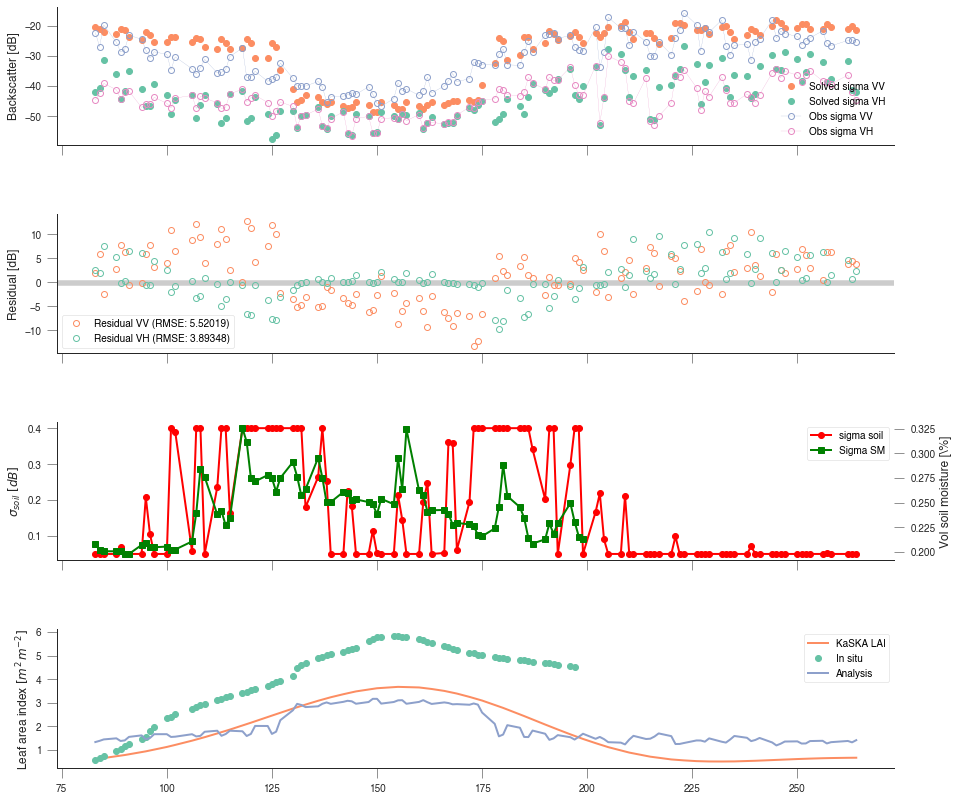

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
field = "508"


doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2



prior_mean = np.concatenate([[0,]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
gamma = 500
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)
print(retval.x[:6])

This is a poorer inversion compared to the model we had last time (just a multiplicative soil model). We also see that the output LAI is completely disrupted. This is pretty worrying. We still get a rubbish soil moisture profile.

👇 This is the old model, which seems to work sort of better than the new one. 

Initial cost 18727.1
Final cost 3016.94
[ -6.82044003   0.13977109 -23.99191055  -7.65024485   0.05537432
 -40.51046277]


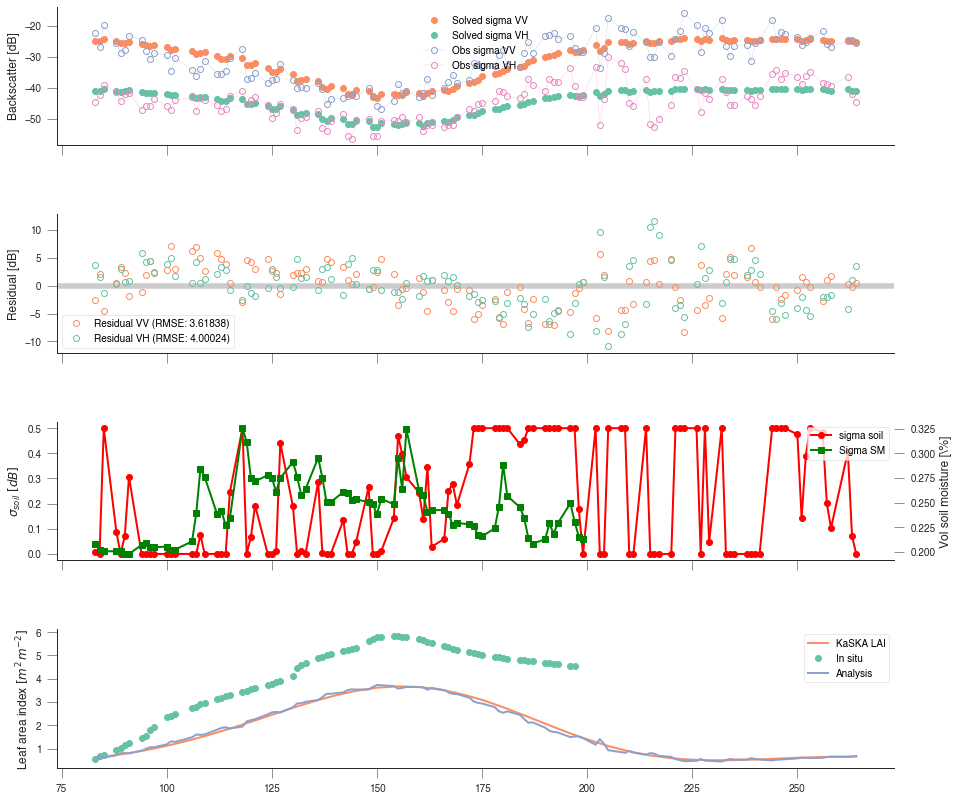

In [7]:
from scipy.ndimage.filters import gaussian_filter1d
field = "508"


doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2



prior_mean = np.concatenate([[0,]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
gamma = 50
retval = invert_field_multiplicative(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots_multiplicative(field, retval, svv, svh, theta, doy, df, s2_lai)
print(retval.x[:6])

So a simpler model (in terms of soil) does better. A reason for this could be differences due to passes/orbits. We can try to fit the data to individual orbits, and see how consistent the solution and paremters are.

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Initial cost 70749.8
Final cost 24635
Orbit 44 [-3.4829366   2.62695959 -0.47827001 -1.26611425 -0.57130181 -3.62152575]
Initial cost 83808.8
Final cost 3967.68
Orbit 95 [-15.56879525   3.49463489  -1.77274909  -1.76017071  -0.6616601
  -3.91938889]
Initial cost 81656.8
Final cost 3935.53
Orbit 117 [-15.74605802   2.52901009  -2.02881017  -1.73370177  -0.67728324
  -3.93155662]
Initial cost 72812.2
Final cost 24474.5
Orbit 168 [-2.88127615  1.35147666 -0.47298384 -1.11860748 -0.59207475 -3.03152792]


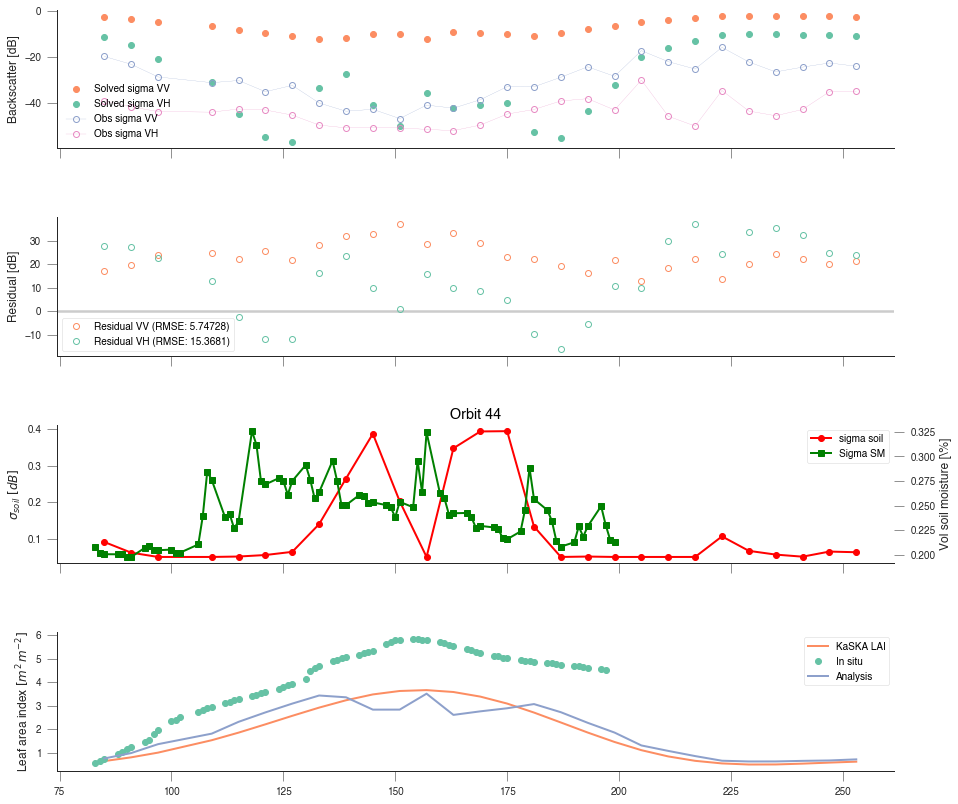

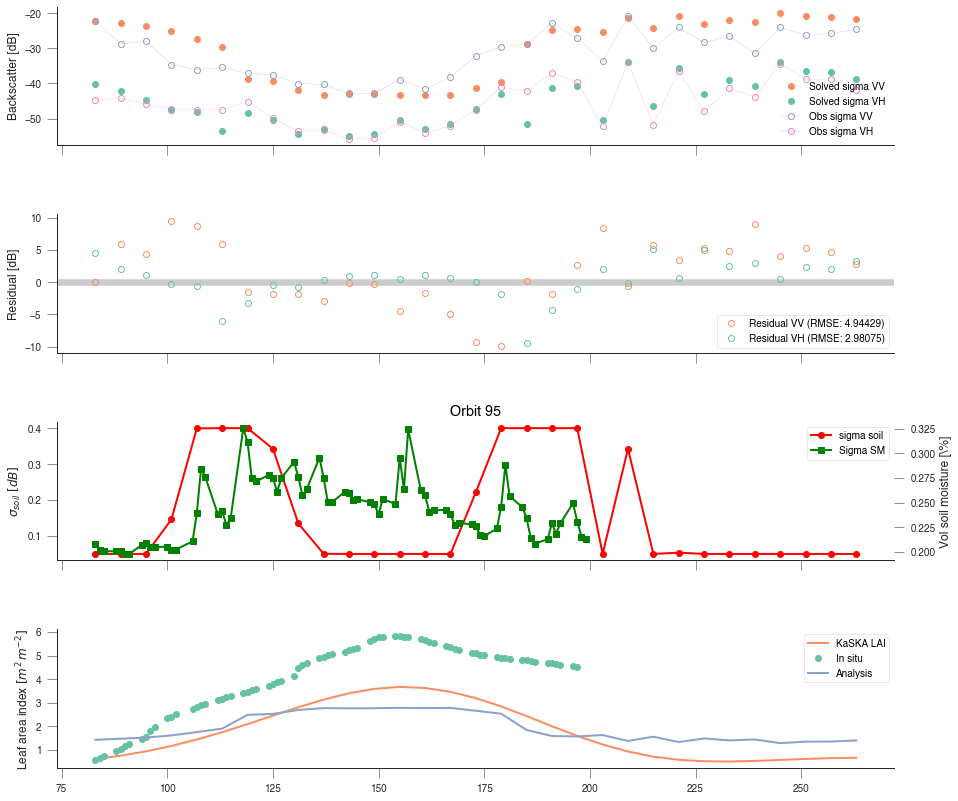

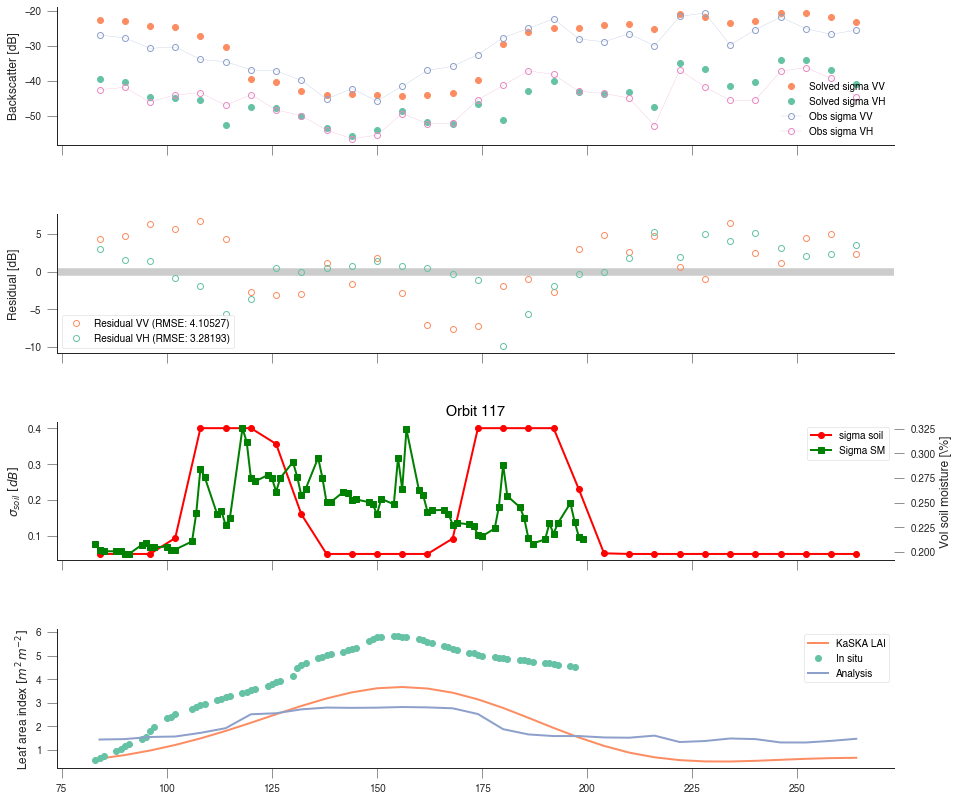

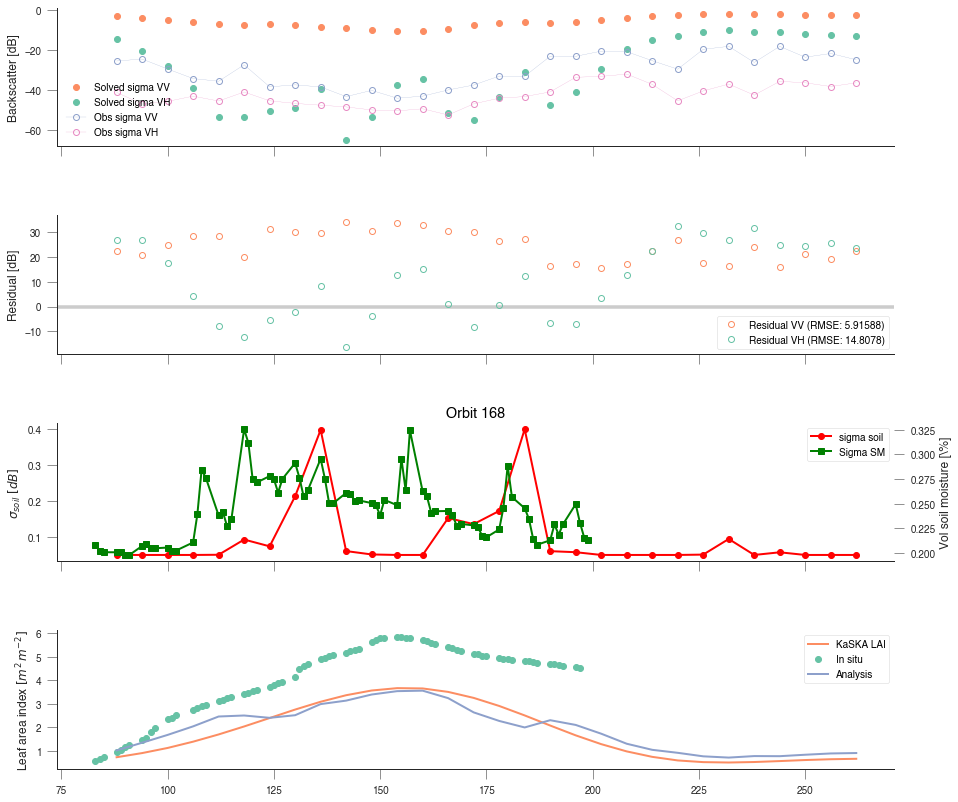

In [8]:

per_orbit_data = prepare_field_data(field, df, df_s2, ignore_orbits=False )


for orbit, orbit_data in per_orbit_data.items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data
    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                            for field in fields], axis=0)
    sm_std[sm_std == 0] = 0.2



    prior_mean = np.concatenate([[0,]*6, sm_mean, s2_lai])
    prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
    gamma = 500
    retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

    do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)
    print(f"Orbit {orbit:d}", retval.x[:6])
    plt.title(f"Orbit {orbit:d}")

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Initial cost 6162.12
Final cost nan
Orbit 44 [-2.47168749e+01  3.06733175e-02 -2.33952800e+01 -1.49982373e+01
  2.61812642e-02 -4.01104478e+01]
Initial cost 5412.86
Final cost nan
Orbit 95 [-1.24678326e+01  4.03993539e-02 -2.68622760e+01 -1.09656591e+01
  3.37664412e-02 -4.22617018e+01]
Initial cost 4901.16
Final cost 1596.72
Orbit 117 [-1.18028309e+01  4.89337528e-02 -2.59222186e+01 -8.85439393e+00
  3.91958740e-02 -4.21839693e+01]
Initial cost 6195.29
Final cost nan
Orbit 168 [-12.55863789   0.06138506 -23.83446504  -7.80717423   0.0560988
 -39.31434059]


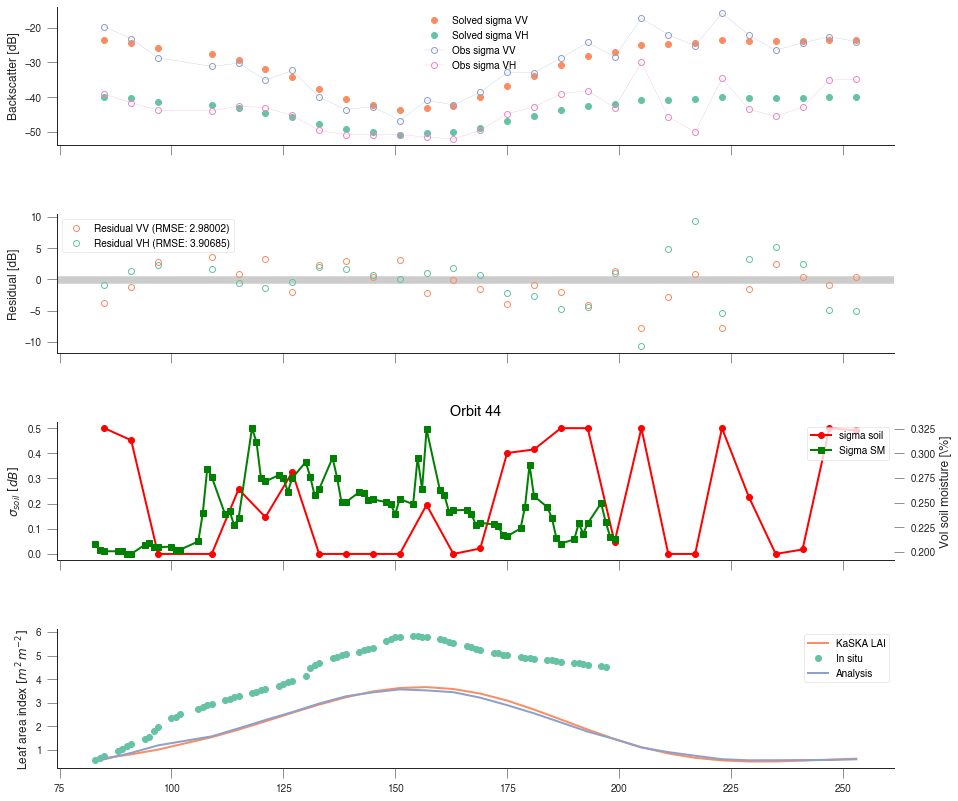

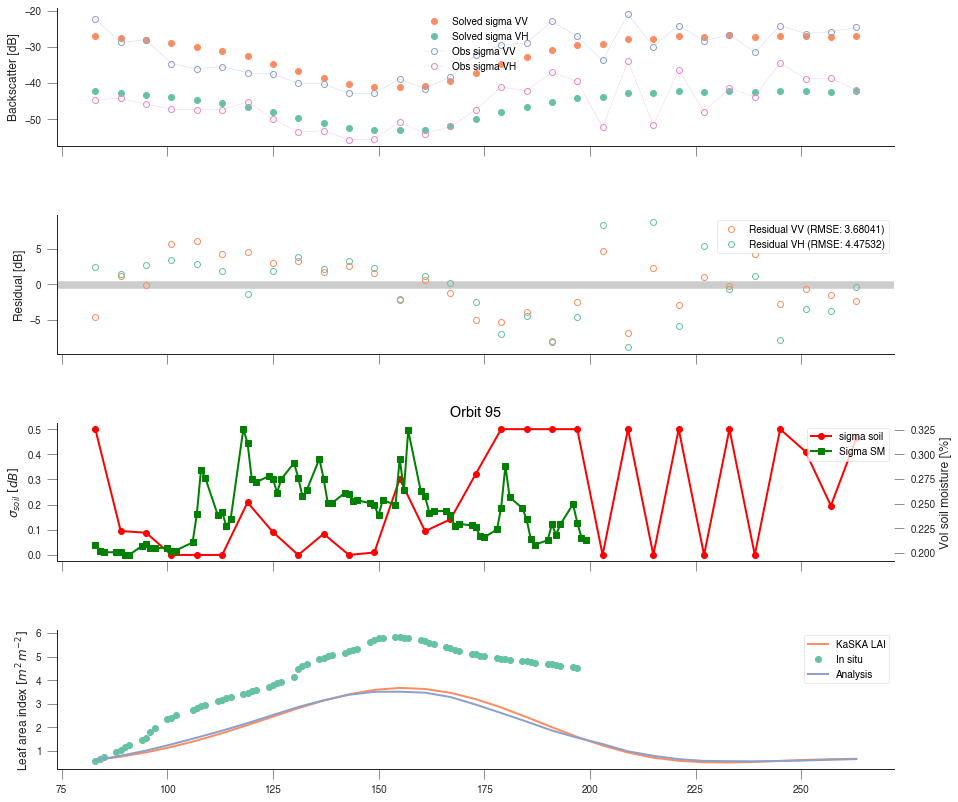

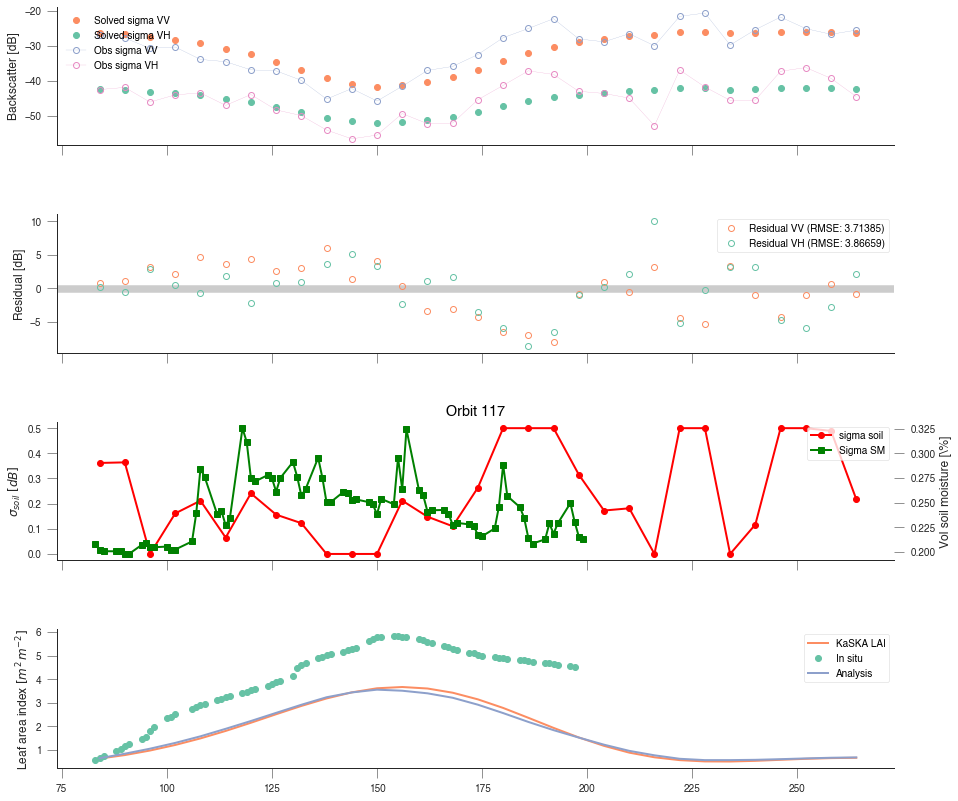

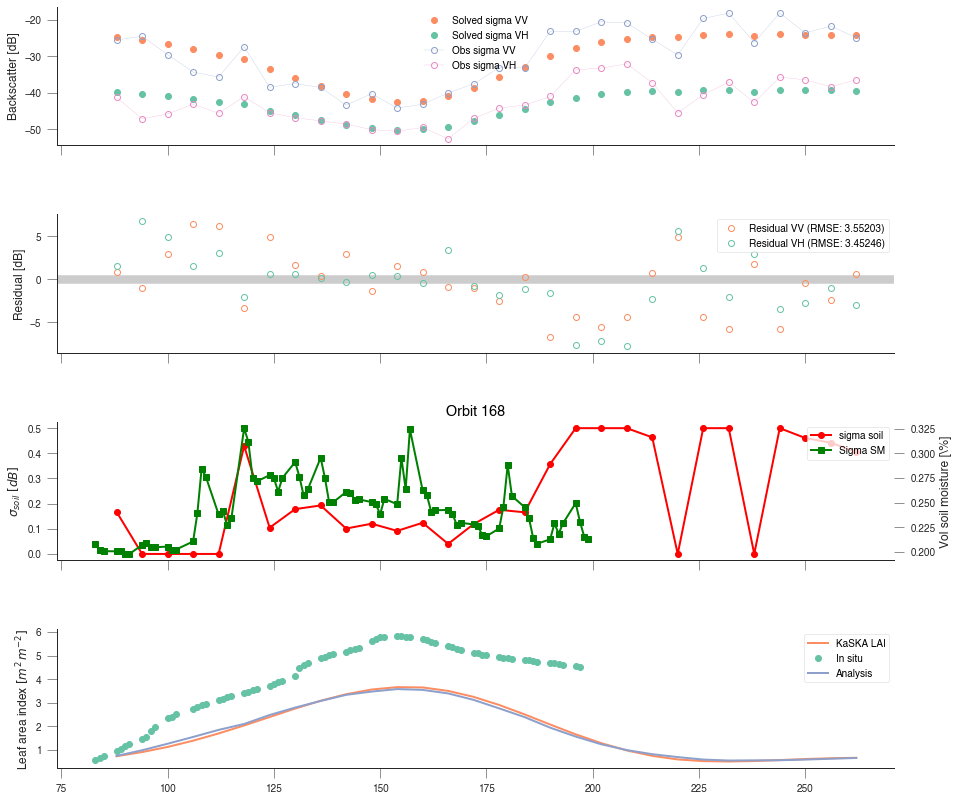

In [9]:

per_orbit_data = prepare_field_data(field, df, df_s2, ignore_orbits=False )


for orbit, orbit_data in per_orbit_data.items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data
    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                            for field in fields], axis=0)
    sm_std[sm_std == 0] = 0.2



    prior_mean = np.concatenate([[0,]*6, sm_mean, s2_lai])
    prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
    gamma = 500
    retval = invert_field_multiplicative(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

    do_plots_multiplicative(field, retval, svv, svh, theta, doy, df, s2_lai)
    print(f"Orbit {orbit:d}", retval.x[:6])
    plt.title(f"Orbit {orbit:d}")

Again, despita a couple of glitches, the simpler model seems to work better: fits the data better and doesn't destroy the LAI profile. Whether we get any meaningful soil moisture is pretty dubious, but if we consider the WCM canopy parameters (for field 508, "old model"), we can have a look at the canopy attenuation (see below). The attenuation for the VV polarisation is quite signficant when LAI goes up to 2, whereas the decay for VH is not so sharp. In comparison, the soil model has a much lower signal level, so for high LAI, the soil moisture isn't updated, and stays close to the prior (this is expected!).

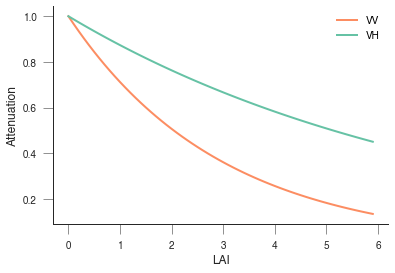

In [10]:
B_vv = 0.139
B_vh = 0.0553
mu = np.cos(np.deg2rad(35.)) #Say
v2 = np.arange(0, 6, 0.1)
plt.plot(v2, np.exp(-2 * B_vv * v2 / mu), '-', label="VV")
plt.plot(v2, np.exp(-2 * B_vh * v2 / mu), '-', label="VH")
plt.xlabel("LAI")
plt.ylabel("Attenuation")
plt.legend(loc="best", frameon=False)#


## Further strategies for simplifying the soil model

Let us now assume that we have a new soil model that is as above, but now has scaling parameters for roughness and soil moisture. Assume also that roughness is slowly varying, and let's apply the model to the entire time series (although we know that we can't really make it stick when the LAI starts to rise):

In [11]:
def soil_moisture_model(a, b, rough, mv, theta, pol="HV"):
    K = np.log10(0.11*(np.cos(theta)**2.2))
    if pol.upper() == "VV":
        K = K - np.log10(0.095*(0.13 + np.sin(1.5*theta))**1.4)
    return K + a*rough + b*mv

passer = s2_lai>0

def cost_smooth(x, gamma):
    """A smoother for one parameter (e.g. LAI or whatever).
    `gamma` controls the magnitude of the smoothing (higher
    `gamma`, more smoothing)
    """
    # Calculate differences
    p_diff1 = x[1:-1] - x[2:]
    p_diff2 = x[1:-1] - x[:-2]
    # Cost function
    xcost_model = 0.5 * gamma * np.sum(p_diff1 ** 2 + p_diff2 ** 2)
    # Jacobian
    xdcost_model = 1 * gamma * (p_diff1 + p_diff2)
    # Note that we miss the first and last elements of the Jacobian
    # They're zero!
    return xcost_model, xdcost_model

def cost(x, svv, svh, theta, passer, gamma_rough=1, unc=0.5, fwd=False):
    svv = svv[passer]
    svh = svh[passer]
    theta = np.deg2rad(theta[passer])
    n_obs = len(svv)
    a_vv,  b_vv,  a_vh, b_vh = x[:4]
    mv = x[4:(4+n_obs)]
    rough = x[(4+n_obs):]
    fwd_svv = soil_moisture_model(a_vv, b_vv, rough, mv, theta, pol="VV")
    fwd_svh = soil_moisture_model(a_vh, b_vh, rough, mv, theta, pol="HV")
    diff_vv = fwd_svv - svv
    diff_vh = fwd_svh - svh
    cost = 0.5*(diff_vv**2 + diff_vh**2)/unc**2
    cost_rough, dcost_rough = cost_smooth(rough, gamma_rough)
    #jac = diff_vv*d_svv + diff_vh*d_svh
    if fwd:
        return cost.sum() + cost_rough.sum(), fwd_svv, fwd_svh
    else:
        return cost.sum() + cost_rough.sum()#, jac

#svv = np.array(svv.to_list())
#svh = np.array(svh.to_list())
#theta = np.array(theta.to_list())
n_obs = np.sum(passer)
#bounds = [[None, None],]*2 + [[0.01, 0.5],]*n_obs
x0 = np.concatenate([np.zeros(4), np.ones(n_obs)*0.2, np.ones(n_obs)])
retval = scipy.optimize.minimize(cost, x0, jac=False, args=(svv, svh, theta, passer, 5e3),
                                 method="L-BFGS-B",
                                options={"disp": True})#,bounds = bounds)
    


162654.67967339462
[-20.38572814  -7.24456217 -67.47820672  -5.37325694]


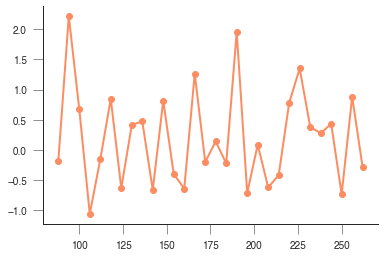

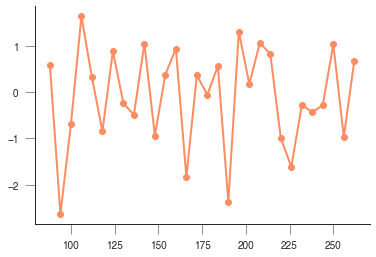

In [12]:
print(cost(x0, svv, svh, theta, passer))
c, fwd_svv, fwd_svh = cost(retval.x, svv, svh, theta, passer, fwd=True)
plt.plot(doy[passer], svv[passer] - fwd_svv, '-o')
plt.figure()
plt.plot(doy[passer], svh[passer] - fwd_svh, '-o')
#plt.semilogy(doy[passer], svh[passer] - fwd_svh, '-o')
print(retval.x[:4])
# plt.plot(doy[passer], fwd_svv, '-')
# plt.plot(doy[passer], fwd_svh, '-')

No handles with labels found to put in legend.


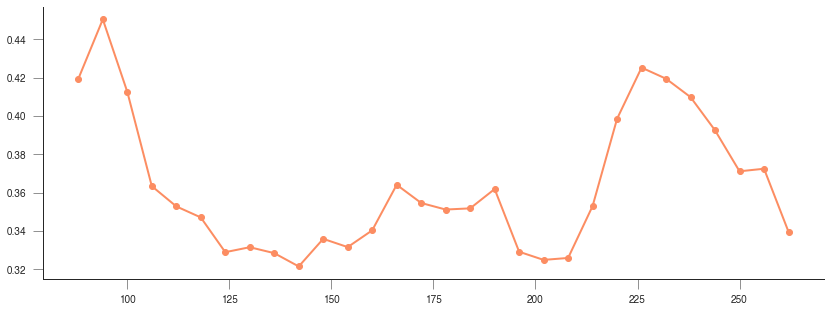

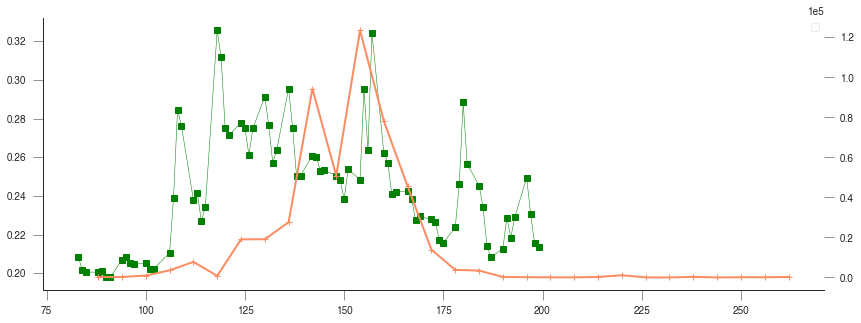

In [13]:
#plt.plot(doy[passer], svv[passer], 'o')
#plt.plot(doy[passer], svh[passer], 'o')
#plt.plot(doy[passer], 10**retval.x[4:(n_obs+4)], "-+")
plt.figure(figsize=(14,5))
plt.plot(doy[passer], retval.x[(4+n_obs):], "-o")
plt.figure(figsize=(14,5))
plt.plot(
        df[f"doy_{field:s}"], df[f"SM_{field:s}"], "s-g", lw=0.5, label="Sigma SM"
    )
plt.twinx()
plt.plot(doy[passer], 10**retval.x[4:(4+n_obs)], "-+")
plt.legend()

That's *not* that bad. We can see that for the little "crop free" period (~DoY<100), we can track the in situ signal (never mind the units!). So a simple additive model as precluded here is probably sufficient. This could be used, and one could flag users that for high LAI, they shouldn't trust the soil moisture.

Another approach is the one that uses consecutive acquisitions to invert soil moisture. The broad idea behind this is that, for **bare soils** that are not very rough, we can assume that the soil backscatter is the product of a two functions, one encoding the effect of the dielectric constant, and the other encoding the effect of roughness. You can even have a canopy attenuation factor. All in all, for two consecutive days, the difference in backscatter is due to changes in moisture (i.e. we assume roughness and vegetation are slowly evolving). The variation in backscatter due to dielectric properties and angle is given by the Fresnel reflection coefficient. We can also assume that the dielectric constant is a quadratic function of soil moisture (e.g. Hallikainen et al., 1985).

$$
F_{VV}(\epsilon, \theta)=\frac{ (\epsilon-1)\sin\theta^2 - \epsilon(1+\sin\theta^2)}{\left[\epsilon\cos\theta + \sqrt{\epsilon-\sin\theta^2}   \right]^2}
$$

and 
$$
\epsilon = a + b\cdot m_v + c\cdot m_v^2
$$

This leads to a constrained least squares problem (it's linear, but here we solve it non-linearly for convenience). The examples from three of the LMU fields are shown below. We have concentrated in DoY 80 to 100, as within this period we have no canopy to annoy us.


In [16]:


def cost(alphas, sr):
    J = 0
    for i in range(len(alphas)-1):
        J += (alphas[i] - sr[i] * alphas[i+1])**2
    return J

def fresnel(eps, theta):
    theta = np.deg2rad(theta)
    num = (eps-1)*(np.sin(theta)**2 - eps*(1+np.sin(theta)**2))
    den = eps*np.cos(theta) + np.sqrt(eps - np.sin(theta)**2)
    den = den**2
    return np.abs(num/den)

def mv2eps(a, b, c, mv):
    eps = a + b * mv + c * mv**2
    return eps

def cost_cost(p, theta, svv):
    lsvv = 10**(svv[: num_day]/ 10 )
    sr = np.sqrt(lsvv[:-1]/lsvv[1:])
    a,b,c = p[:3]
    mv = p[3:]
    eps = mv2eps(a, b, c, mv)
    alphas = fresnel(eps, theta)
    return cost(alphas, svv)

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


301 => a=0.871140; b=0.505114; c=0.423432
301 => a=0.866648; b=0.507245; c=0.424633
301 => a=0.869018; b=0.506192; c=0.424028
301 => a=0.880705; b=0.501052; c=0.421225
508 => a=0.884109; b=0.499293; c=0.420351
508 => a=0.877967; b=0.503442; c=0.422351
508 => a=0.883910; b=0.499916; c=0.420612
508 => a=0.884049; b=0.499467; c=0.420423
542 => a=0.847041; b=0.513968; c=0.429031
542 => a=0.833703; b=0.518996; c=0.432612
542 => a=0.847618; b=0.513448; c=0.428749
542 => a=0.851438; b=0.512550; c=0.428037


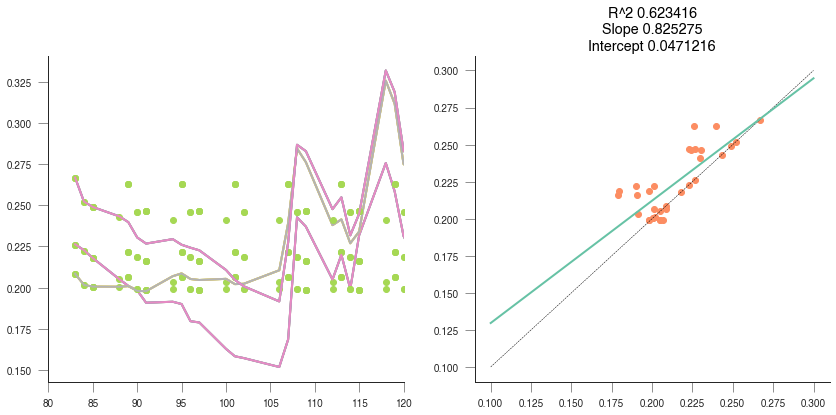

In [25]:
soil_parameters = {}
retrieved_soil_moisture = {}
in_situ_soil_moisture = {}

num_day = 20
bounds = [[None, None]] * 3 + [[0.1, 0.5]] * num_day
xs = []
ys = []
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs = axs.flatten()
for field in ["301", "508", "542"]:
    soil_parameters[field] = []
    retrieved_soil_moisture[field] = []
    in_situ_soil_moisture[field] = []

    dpasser = np.logical_and(df[f"doy_{field:s}"].values >= 80,
                             df[f"doy_{field:s}"].values <= 140)

    in_situ_soil_moisture[field] = np.c_[df[f"doy_{field:s}"][dpasser],
                                         df[f"SM_{field:s}"][dpasser]]

    for orbit_num, orbit_data in prepare_field_data(
            field, df, df_s2, ignore_orbits=False).items():
        doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data

        tmv = np.array(df[f"SM_{field:s}"][df[f"doy_{field:s}"] == doy[0]])

        x0 = (np.ones(3) * 0.4).tolist() + (np.ones(num_day) * tmv).tolist()

        retval = scipy.optimize.minimize(cost_cost,
                                         x0,
                                         jac=False,
                                         args=(theta[:num_day], svv[:num_day]),
                                         method="L-BFGS-B",
                                         options={"disp": True},
                                         bounds=bounds)
        soil_parameters[field].append(retval.x[:3])
        retrieved_soil_moisture[field].append(
            np.c_[doy[:num_day], retval.x[3:]])
        mask = (doy[:num_day] > 80) & (doy[:num_day] < 100)
        xs += retval.x[3:][mask].tolist()
        ys += [
            df[f"SM_{field:s}"][df[f"doy_{field:s}"] == ii].values[0]
            for ii in doy[:num_day][mask]
        ]

        for xx in retrieved_soil_moisture[field]:

            axs[0].plot(xx[:, 0], xx[:, 1], 'o', c="#A6D854")
        axs[0].plot(in_situ_soil_moisture[field][:, 0],
                 in_situ_soil_moisture[field][:, 1], '-')#, c="#E78AC3")
        axs[0].set_xlim(80, 120)

axs[1].plot(ys, xs, 'o')
from scipy.stats import linregress

retval = linregress(ys, xs)
axs[1].plot([0.1, 0.3], [0.1, 0.3], 'k--', lw=0.5)
xx = np.array([0.1, 0.3])
axs[1].plot(xx, retval.slope*xx + retval.intercept, '-')
axs[1].set_title(f"R^2 {retval.rvalue**2:g}\nSlope {retval.slope:g}\nIntercept {retval.intercept:g}")
for k,v in soil_parameters.items():
    n_orbits = len(v)
    for i in range(n_orbits):
        print(f"{k:s} => a={v[i][0]:f}; b={v[i][1]:f}; c={v[i][2]:f}")

All in all, this looks quite hopeful. The prcoessing has been separated by orbit, and it is worth noting that the results are very dependent on starting values. We also note that the $a$, $b$ and $c$ parameters are quite stable, and that we could even put some form of prior on them (Hallikainen et al 1985 derive typical values based on sand and clay content). We haven't even put any prior constraint on soil moisture, which means that when we have an observation gap, we end up loosing the plot a bit.



# A new soil under your feet

In [26]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations

    """
    p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    q = 0.095 * (0.13 + np.sin(1.5*theta))**1.4 * (1-np.exp(-1.3 * ks**0.9))
    a = 0.11 * mv**0.7 * np.cos(theta)**2.2
    b = 1 - np.exp(-0.32 * ks**1.8)
    hv = a*b
    vv = a*b/q
    hh = hv/q*p
    return hh, vv, hv
    

def wcm(A, V1, B, V2, mv, ks, theta=23, pol="VV"):
    """WCM model with Oh2004 model. The main
    assumption here is that we only consider first
    order effects. The vegetation backscatter contribution
    is given by `A*V1`, which is often related to scatterer
    (e.g. leaves, stems, ...) properties. The attenuation
    due to the canopy is controlled by `B*V2`, which is
    often related to canopy moisture content (this is polarisation
    and frequency dependent). The soil backscatter is modelled as
    using an Oh2004 model.
    """
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    sigma_soil = soil_backscatter(mv, ks, np.deg2rad(theta))
    isel = ["HH", "VV", "HV"].index(pol.upper())
    
    soil = tau*(10*np.log10(sigma_soil[isel]))
    return veg + soil




NameError: name 'soil_backscatter' is not defined

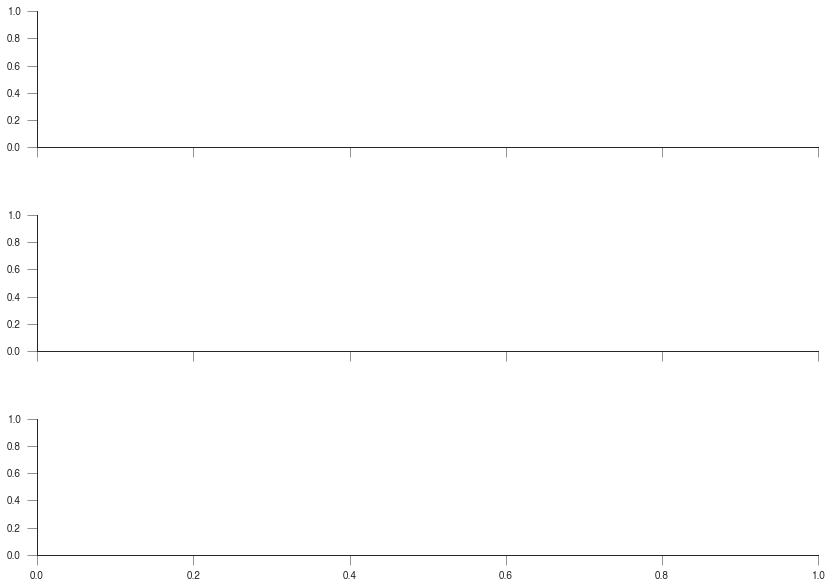

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, squeeze=True,
                       figsize=(14,10))
axs = axs.flatten()
for ks in np.logspace(np.log10(2), np.log10(10.), 10):
    shh = [] ; svv = [] ; svh = []
    
    for sm in np.linspace(0, 0.5, 10):
        sigmas = soil_backscatter(sm, ks, np.deg2rad(45))
        shh.append(sigmas[0])
        svv.append(sigmas[1])
        svh.append(sigmas[2])
    axs[0].plot(np.linspace(0, 0.5, 10), 10*np.log(shh), '-', label="%g"%ks)
    axs[1].plot(np.linspace(0, 0.5, 10), 10*np.log(svv), '-', label="%g"%ks)
    axs[2].plot(np.linspace(0, 0.5, 10), 10*np.log(svh), '-', label="%g"%ks)
axs[0].legend(loc="best")
axs[1].legend(loc="best")
axs[2].legend(loc="best")
axs[0].set_ylabel("HH")
axs[1].set_ylabel("VV")
axs[2].set_ylabel("VH")
    

In [28]:
field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.2, ]*n_obs])
gamma = 50
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)


Initial cost 305199
Final cost 4262.86


AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

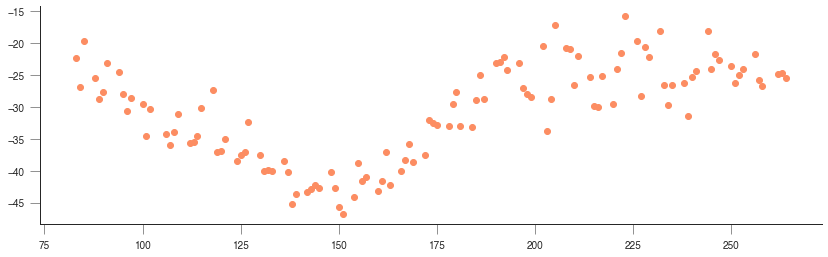

In [29]:
n_obs = len(svv)
A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = retval.x[:6]
vsm = retval.x[6 : (6 + n_obs)]
lai = retval.x[(6 + n_obs) :]


plt.figure(figsize=(14,4))
plt.plot(doy, svv, 'o')
k = 50
sim_vv = wcm(A_vv, lai, B_vv, lai, C_vv, vsm, k, theta=np.array(theta.to_list()), pol="VV")
plt.plot(doy, sim_vv, '-')
plt.figure(figsize=(14,4))
plt.plot(doy, svh, 'o')
k = 100
sim_vh = wcm(A_vh, lai, B_vh, lai, C_vh, vsm, k, theta=np.array(theta.to_list()), pol="HV")
plt.plot(doy, sim_vh, '-')

k = 50
sim_vh = wcm(A_vh, lai, B_vh, lai, C_vh, 100*vsm, k, theta=np.array(theta.to_list()), pol="HV")
plt.plot(doy, sim_vh, '-')

In [30]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations

    """
    p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    q = 0.095 * (0.13 + np.sin(1.5*theta))**1.4 * (1-np.exp(-1.3 * ks**0.9))
    a = 0.11 * mv**0.7 * np.cos(theta)**2.2
    b = 1 - np.exp(-0.32 * ks**1.8)
    hv = a*b
    vv = a*b/q
    hh = hv/q*p
    return hh, vv, hv
    

def wcm(A, V1, B, V2, mv, ks, theta=23, pol="VV"):
    """WCM model with Oh2004 model. The main
    assumption here is that we only consider first
    order effects. The vegetation backscatter contribution
    is given by `A*V1`, which is often related to scatterer
    (e.g. leaves, stems, ...) properties. The attenuation
    due to the canopy is controlled by `B*V2`, which is
    often related to canopy moisture content (this is polarisation
    and frequency dependent). The soil backscatter is modelled as
    using an Oh2004 model.
    """
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    sigma_soil = soil_backscatter(mv, ks, np.deg2rad(theta))
    isel = ["HH", "VV", "HV"].index(pol.upper())
    soil = tau*sigma_soil[isel]
    return veg + soil


def cost_obs(x, svh, svv, theta, unc=0.5):
    """Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    Uncertainty is the uncertainty in backscatter, and
    assume that there are two polarisations (VV and VH),
    although these are just labels!
    """
    n_obs = svh.shape[0]
    A_vv, B_vv, A_vh, B_vh, ks = x[:5]
    vsm = x[5 : (5 + n_obs)]
    lai = x[(5 + n_obs) :]
    sigma_vv = wcm(A_vv, lai, B_vv, lai, vsm, ks, theta=theta, pol="VV")
    sigma_vh = wcm(A_vv, lai, B_vv, lai, vsm, ks, theta=theta, pol="HV")
    diff_vv = svv - sigma_vv
    diff_vh = svh - sigma_vh
    cost = 0.5 * (diff_vv ** 2 + diff_vh ** 2) / (unc ** 2)
    return cost.sum()#, -jac / (unc ** 2)


def cost_prior(x, svh, svv, theta, prior_mean, prior_unc):
    """A Gaussian cost function prior. We assume no correlations
    between parameters, only mean and standard deviation.
    Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    """
    n_obs = len(svh)
    prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
    dprior_cost = -(prior_mean - x) / prior_unc ** 2
    dprior_cost[:6] = 0.0
    return (prior_cost[6:]).sum()#, dprior_cost


def cost_smooth(x, gamma):
    """A smoother for one parameter (e.g. LAI or whatever).
    `gamma` controls the magnitude of the smoothing (higher
    `gamma`, more smoothing)
    """
    # Calculate differences
    p_diff1 = x[1:-1] - x[2:]
    p_diff2 = x[1:-1] - x[:-2]
    # Cost function
    xcost_model = 0.5 * gamma * np.sum(p_diff1 ** 2 + p_diff2 ** 2)
    # Jacobian
    xdcost_model = 1 * gamma * (p_diff1 + p_diff2)
    # Note that we miss the first and last elements of the Jacobian
    # They're zero!
    return xcost_model#, xdcost_model


def cost_function(x, svh, svv, theta, gamma, prior_mean, prior_unc, unc=0.8):
    """A combined cost function that calls the prior, fit to the observations
    """
    # Fit to the observations
    cost1 = cost_obs(x, svh, svv, theta, unc=unc)
    # Fit to the prior
    cost2 = cost_prior(x, svh, svv, theta, prior_mean, prior_unc)
    # Smooth evolution of LAI
    n_obs = len(svv)
    lai = x[(6 + n_obs) :]
    cost3 = cost_smooth(lai, gamma)
    #tmp = np.zeros_like(dcost1)
    #tmp[(7 + n_obs) : -1] = dcost3
    return cost1 + cost2 + cost3#, dcost1 + dcost2 + tmp


field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*5, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*5, sm_std, [0.2, ]*n_obs])
gamma = 150


n_obs = len(svv)
# Do some dodgy starting point guessing
# In reality, this should come from a sensible prior mean, but for the
# time being...
sm0 = prior_mean[5 : (5 + n_obs)]
A_vv0, B_vv0, A_vh0, B_vh0, ks = -20, 0.5, -20, 0.5,  4.
x0 = np.concatenate([np.array([A_vv0, B_vv0, A_vh0, B_vh0, ks]), sm0, s2_lai])
print(sm0.shape, prior_mean.shape, x0.shape)
# Put some parameter bounds so we don't end up with crazy numbers
bounds = (
        [[None, None]] * 5
        + [[0, 0.5]] * s2_lai.shape[0]
        + [[0, 8]] * s2_lai.shape[0]
    )
# Minimise the log-posterior
retval = scipy.optimize.minimize(
        cost_function,
        x0,
        bounds=bounds,
        args=(svh, svv, theta, gamma, prior_mean, prior_sd),
        tol=1e-10,
        options={"disp": True},
    )
print(
        f"Initial cost {cost_function(x0,svh, svv, theta,gamma, prior_mean, prior_sd):g}"
    )
print(f"Final cost {retval.fun:g}")

(120,) (245,) (245,)


NameError: name 'soil_backscatter' is not defined

In [ ]:
plt.plot(doy,retval.x[5:(5+n_obs)])
plt.plot(
        df[f"doy_{field:s}"], df[f"SM_{field:s}"], "s-g")


In [ ]:
retval.x[:6]